In [ ]:
#make core bundle profile
#dice coef of visitation map

In [3]:
from glob import glob
import os.path as op
import numpy as np
import matplotlib.pyplot as plt
import bundlenet as bn

In [180]:
subj='970764'
loaded_from_file = np.load('model_p/p_subj'+ subj + '_nclass16_do0_nc3_fc1.npz')
labels_concat = loaded_from_file['labels']
p_concat = loaded_from_file['p']
for subj in '971160','972566','973770','978578','979984','983773':
    loaded_from_file = np.load('model_p/p_subj'+ subj + '_nclass16_do0_nc3_fc1.npz')
    labels_subj = loaded_from_file['labels']
    p_subj = loaded_from_file['p']
    labels_concat = np.concatenate((labels_concat,labels_subj))
    p_concat = np.concatenate((p_concat,p_subj))

In [181]:
subj='984472'#'100307'##
loaded_from_file = np.load('model_p/p_subj'+ subj + '_nclass16_do0_nc3_fc1.npz')
labels_test = loaded_from_file['labels']
p_test = loaded_from_file['p']

In [182]:
#make binary labels
labels_concat_2class = labels_concat.copy()
labels_concat_2class[labels_concat_2class<16] = 0
labels_concat_2class[labels_concat_2class==16] = 1
labels_test_2class = labels_test.copy()
labels_test_2class[labels_test_2class<16] = 0
labels_test_2class[labels_test_2class==16] = 1
p_2class = bn.run_xgboost(p_concat,labels_concat_2class,p_test,labels_test_2class,5,2,0.5)

In [183]:
from sklearn.metrics import precision_recall_fscore_support as score

In [184]:
precision, recall, fscore, support = score(labels_test_2class,p_2class)

In [185]:
precision

array([0.79956823, 0.96057385])

In [186]:
recall

array([0.76383933, 0.96779362])

In [187]:
keep = p_2class==0
labels = labels_test[keep]
p_idx = np.argmax(p_test,axis=-1)
p = p_idx[keep]

In [188]:
np.sum(labels==16)/len(labels)

0.20043177301076007

In [189]:
len(labels)

29182

In [190]:
precision, recall, fscore, support = score(labels,p)
precision = precision[0:16]
recall = recall[0:16]

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [191]:
bundle_files = sorted(glob('/home/ubuntu/Atlas_in_MNI_Space_16_bundles/bundles/*.trk'))
bundle_names = []
for fname in bundle_files:
    bundle_names.append(fname.split('/')[-1].split('bundles_')[-1].split('.trk')[0])
    

In [192]:
bundle_names

['AF_L',
 'AF_R',
 'CCMid',
 'CC_ForcepsMajor',
 'CC_ForcepsMinor',
 'CST_L',
 'CST_R',
 'C_L',
 'C_R',
 'F_L',
 'F_R',
 'IF0F_R',
 'IFOF_L',
 'MCP',
 'UF_L',
 'UF_R']

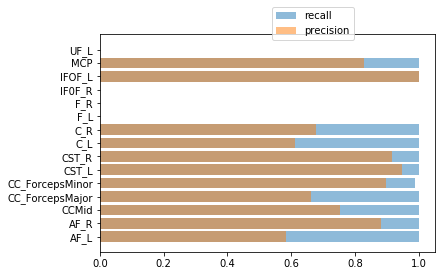

In [193]:
plt.barh(np.arange(len(recall)), recall, align='center', alpha=0.5,label='recall')
plt.barh(np.arange(len(precision)), precision, align='center', alpha=0.5,label='precision')
plt.yticks(np.arange(len(precision)), bundle_names)
plt.legend(loc='center left', bbox_to_anchor=(0.5, 1.05))
plt.savefig('precisionrecallbar.pdf')

In [194]:
np.mean(precision)

0.5840654104285118

In [128]:
streamlines_all_nomni = bn.read_sl('/home/ubuntu/copied16/sub-984472/sess-01/dwi/out_work/whole_brain_MNI_tracks_from_peaks__moved.trk')
map_files = sorted(glob('/home/ubuntu/copied16/sub-984472/sess-01/dwi/out_work/rrbs/whole_brain_MNI_tracks_from_peaks__moved_*.npy'))
labeled_index, labels = bn.getlabeledstreamlines(map_files)
unlabeled_index = bn.getunlabeledstreamlines(len(streamlines_all_nomni), labeled_index, len(streamlines_all_nomni)-len(labeled_index), 0)
streamlines_all_nomni_reordered = [streamlines_all_nomni[i] for i in np.int_(np.append(labeled_index,unlabeled_index))]

In [129]:
streamlines_all_nomni_reordered_keep = [streamlines_all_nomni_reordered[i] for i in range(len(p_2class)) if p_2class[i]==0]

In [130]:
probs = np.max(p_test[keep],axis=1)

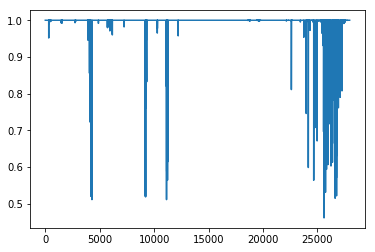

In [131]:
plt.plot(probs)

In [132]:
tmp = np.where((p==1) & (probs > 0.9))
t=tmp[0]

In [133]:
sl_trk = [ streamlines_all_nomni_reordered_keep[i] for i in t]

In [134]:
for i, bund in enumerate(bundle_names):
    bn.savesegtrk(streamlines_all_nomni_reordered_keep, p, i, probs, 0.9,'TRK2/'+bund+'.trk',0)

In [135]:
np.where(p==11)

(array([19800, 19801, 19802, ..., 24475, 25128, 25137]),)

In [136]:
np.where(labels_test==11)

(array([24233, 24234, 24235, ..., 26264, 26265, 26266]),)

In [156]:
t = np.where((p==0) & (probs >0.9))
streamlines_tract_bn = [ streamlines_all_nomni_reordered_keep[i] for i in ]

In [157]:
len(streamlines_tract_bn)

1025

In [173]:
streamlines_tract_reco = bn.read_sl('/home/ubuntu/copied16/sub-984472/sess-01/dwi/out_work/rrbs/whole_brain_MNI_tracks_from_peaks__moved_'+ bundle_names[0] + '__recognized.trk')
len(streamlines_tract_reco)

1596

In [174]:
streamlines_tract_bn=streamlines_all_nomni 
bn_unique=[]
reco_unique=[]
bnreco_overlap=[]

for n_bn in range(len(streamlines_tract_bn)):
    for n_reco in range(len(streamlines_tract_reco)):
        if len(streamlines_tract_reco[n_reco])==len(streamlines_tract_bn[n_bn]):
            if (streamlines_tract_reco[n_reco]==streamlines_tract_bn[n_bn]).any():
                print(n_bn,n_reco)

KeyboardInterrupt: 

In [172]:
len(streamlines_tract_reco[n_reco])

TypeError: object of type 'numpy.int64' has no len()

In [166]:
streamlines_tract_reco = np.load('/home/ubuntu/copied16/sub-984472/sess-01/dwi/out_work/rrbs/whole_brain_MNI_tracks_from_peaks__moved_'+ bundle_names[0] + '__labels.npy')

In [176]:
index_reordered=np.append(labeled_index,unlabeled_index)
index_reordered_keep = [index_reordered[i] for i in range(len(p_2class)) if p_2class[i]==0]

In [177]:
len(index_reordered_keep)

27974